In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [3]:
directory = os.getcwd()
file_path = os.path.join('src', 'datasets')
csv_path = os.path.join(file_path, "jena_climate_2009_2016.csv")
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [32]:
## Parameter Setting For Training
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000

## Parameter in Training 
EVALUATION_INTERVAL = 200
EPOCHS = 20

In [33]:
# Seed Setting for Reproducibility
tf.random.set_seed(13)

In [34]:
## if your PC is equipped with GPU device,tensorflow gpu activation
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus= tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [35]:
## time-series prediction of multi-variate value
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [36]:
multi_data = features.values
multi_data

array([[ 996.52,   -8.02, 1307.75],
       [ 996.57,   -8.41, 1309.8 ],
       [ 996.53,   -8.51, 1310.24],
       ...,
       [ 999.82,   -3.16, 1288.39],
       [ 999.81,   -4.23, 1293.56],
       [ 999.82,   -4.82, 1296.38]])

In [37]:
data_mean = multi_data[:TRAIN_SPLIT].mean(axis=0)
data_std = multi_data[:TRAIN_SPLIT].std(axis=0)
multi_data = (multi_data-data_mean)/data_std

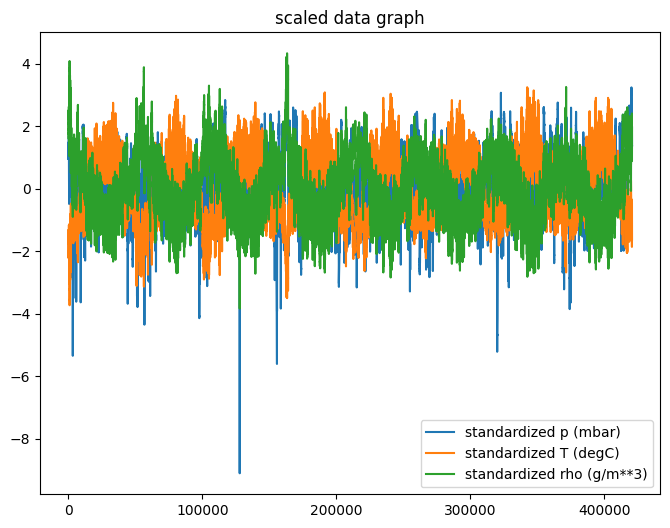

In [38]:
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[0], label='standardized p (mbar)')
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[1], label='standardized T (degC)')
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[2], label='standardized rho (g/m**3)')
plt.title('scaled data graph')
plt.legend()
plt.show()

In [39]:
def multivariate_data(dataset, target, start_index, end_index, data_window, target_size, step, single_step=False):
    data, labels = [],[]
    start_index = start_index + data_window

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-data_window, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [40]:
data_window = 720
future_target = 72
STEP = 6

x_train, y_train = multivariate_data(multi_data, multi_data[:, 1], 0, TRAIN_SPLIT, data_window, future_target, STEP)
x_val, y_val = multivariate_data(multi_data, multi_data[:, 1], TRAIN_SPLIT, None, data_window, future_target, STEP)

In [41]:
print(x_train.shape)
print(y_train.shape)

(299280, 120, 3)
(299280, 72)


In [42]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [43]:
# sequence of model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(72))

# model compile
multi_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae', metrics='mse')

#model fitting
history = multi_step_model.fit(train_data, epochs=EPOCHS, steps_per_epoch = EVALUATION_INTERVAL, validation_data = val_data, validation_steps=50)

Epoch 1/20
200/200 [==============================] - 19s 83ms/step - loss: 0.4568 - mse: 0.3830 - val_loss: 0.2827 - val_mse: 0.1311
Epoch 2/20
200/200 [==============================] - 16s 80ms/step - loss: 0.2978 - mse: 0.1487 - val_loss: 0.2445 - val_mse: 0.1010
Epoch 3/20
200/200 [==============================] - 16s 82ms/step - loss: 0.2578 - mse: 0.1100 - val_loss: 0.2296 - val_mse: 0.0933
Epoch 4/20
200/200 [==============================] - 17s 85ms/step - loss: 0.2285 - mse: 0.0894 - val_loss: 0.2048 - val_mse: 0.0711
Epoch 5/20
200/200 [==============================] - 18s 89ms/step - loss: 0.1904 - mse: 0.0650 - val_loss: 0.1894 - val_mse: 0.0618
Epoch 6/20
200/200 [==============================] - 19s 93ms/step - loss: 0.2001 - mse: 0.0703 - val_loss: 0.2164 - val_mse: 0.0794
Epoch 7/20
200/200 [==============================] - 19s 93ms/step - loss: 0.1944 - mse: 0.0669 - val_loss: 0.2017 - val_mse: 0.0708
Epoch 8/20
200/200 [==============================] - 19s 93ms

In [44]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

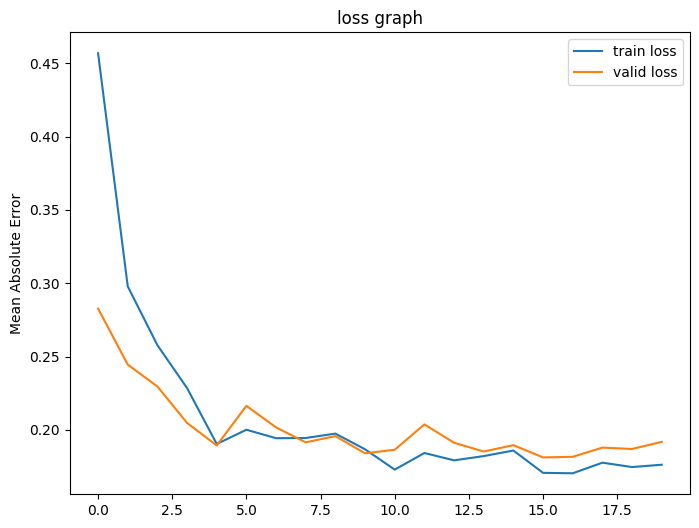

In [45]:
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'], label='train loss')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'], label='valid loss')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.title('loss graph')
plt.show()

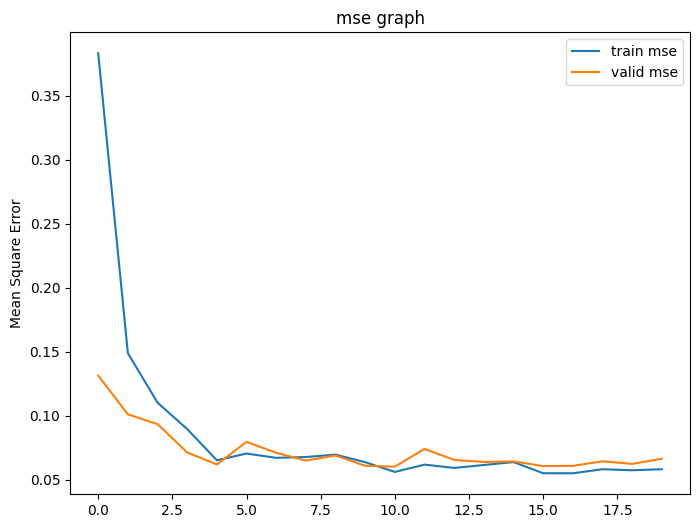

In [46]:
plt.plot(np.arange(len(history.history['mse'])),history.history['mse'], label='train mse')
plt.plot(np.arange(len(history.history['val_mse'])),history.history['val_mse'], label='valid mse')
plt.legend()
plt.ylabel('Mean Square Error')
plt.title('mse graph')
plt.show()

In [47]:
def create_time_steps(length):
    return list(range(-length, 0))

In [48]:
def multi_step_plot(history, true_future, prediction, STEP):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

8/8 [==============================] - 1s 12ms/step


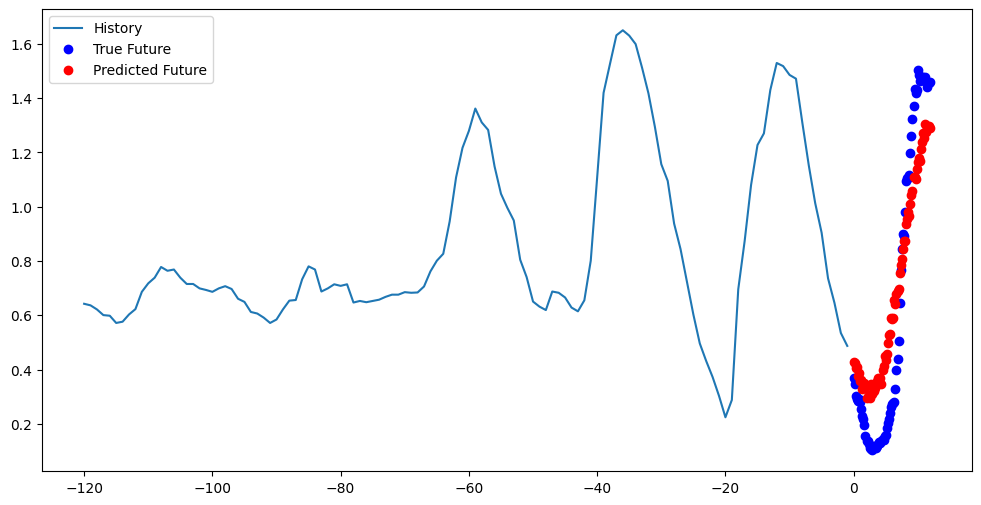

8/8 [==============================] - 0s 12ms/step


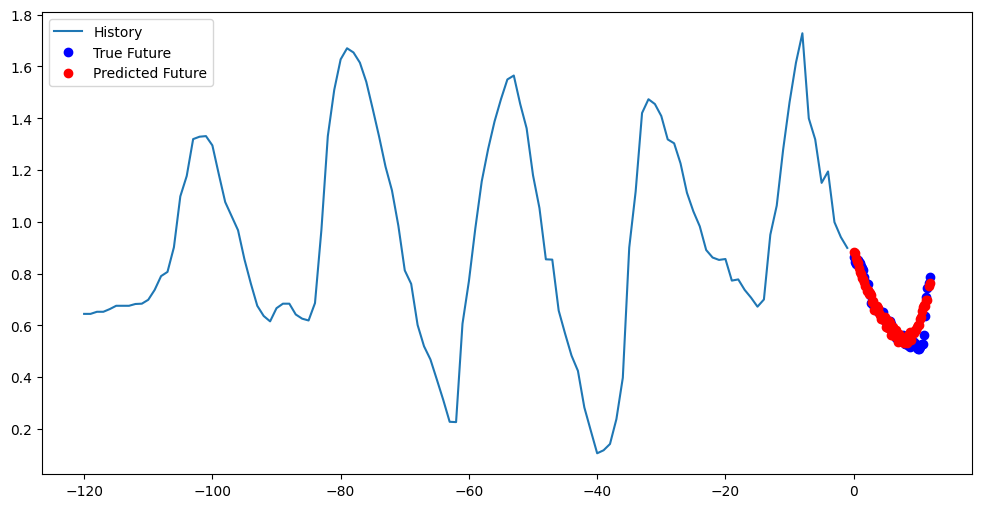

8/8 [==============================] - 0s 12ms/step


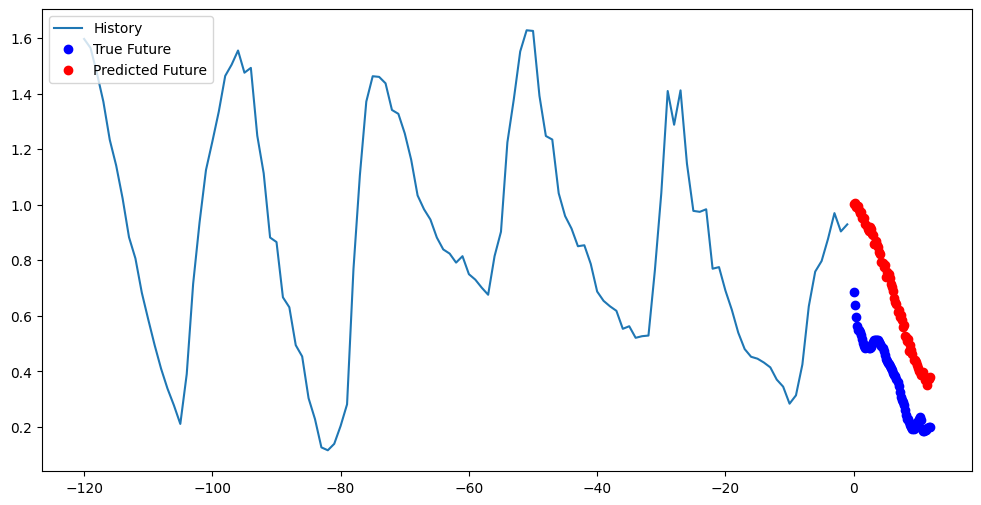

In [49]:
for x, y in val_data.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], STEP)